# Imports and setup

In [2]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmasher as cmr

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../CATS_workshop/cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)

In [3]:
cmap = plt.get_cmap('cmr.ember_r')
mpl.rc('image', cmap=cmap.name)

In [4]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['gd1_helpers.membership.gd1_model'])
importlib.reload(sys.modules['stream_membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership.gd1_model import (
    Base,
    BackgroundModel,
    StreamDensModel,
    OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [5]:
data = at.Table.read("../../CATS_Workshop/cats/data/joined-Jhelum.fits")

#data = at.Table.read('../data/tmp/run_data.fits')
#masks = at.Table.read('../data/tmp/run_data_masks.fits')
cat = data
cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
cat['pm2'] = cat['pm_phi2_unrefl']

In [9]:
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

stream='Jhelum'

p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

In [10]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

2.6490062005275154e-05
Fitting for peak pm location
Pre-fitting mean PM values: -7.480845476411462, 3.4170918408421267


NonFiniteValueError: Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.

In [7]:
##### rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)

        Use @ instead. [gala.coordinates.greatcircle]


In [8]:
Base.setup(p, cat)


((-99.99999968177843, 19.999977507814812),
 {'phi1': (-99.99999968177843, 19.999977507814812),
  'phi2': (-7.970665258306633, 3.3488445561550395),
  'pm1': (-15.099960783639155, -6.0100168343050075),
  'pm2': (-5.4174385931079785, 0.19860289156310484)},
 {'phi1': array([-9.99999997e+01, -9.97999997e+01, -9.95999997e+01, -9.93999997e+01,
         -9.91999997e+01, -9.89999997e+01, -9.87999997e+01, -9.85999997e+01,
         -9.83999997e+01, -9.81999997e+01, -9.79999997e+01, -9.77999997e+01,
         -9.75999997e+01, -9.73999997e+01, -9.71999997e+01, -9.69999997e+01,
         -9.67999997e+01, -9.65999997e+01, -9.63999997e+01, -9.61999997e+01,
         -9.59999997e+01, -9.57999997e+01, -9.55999997e+01, -9.53999997e+01,
         -9.51999997e+01, -9.49999997e+01, -9.47999997e+01, -9.45999997e+01,
         -9.43999997e+01, -9.41999997e+01, -9.39999997e+01, -9.37999997e+01,
         -9.35999997e+01, -9.33999997e+01, -9.31999997e+01, -9.29999997e+01,
         -9.27999997e+01, -9.25999997e+01, -9

In [9]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [10]:
len(bkg_data['phi1'])

36459

In [11]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

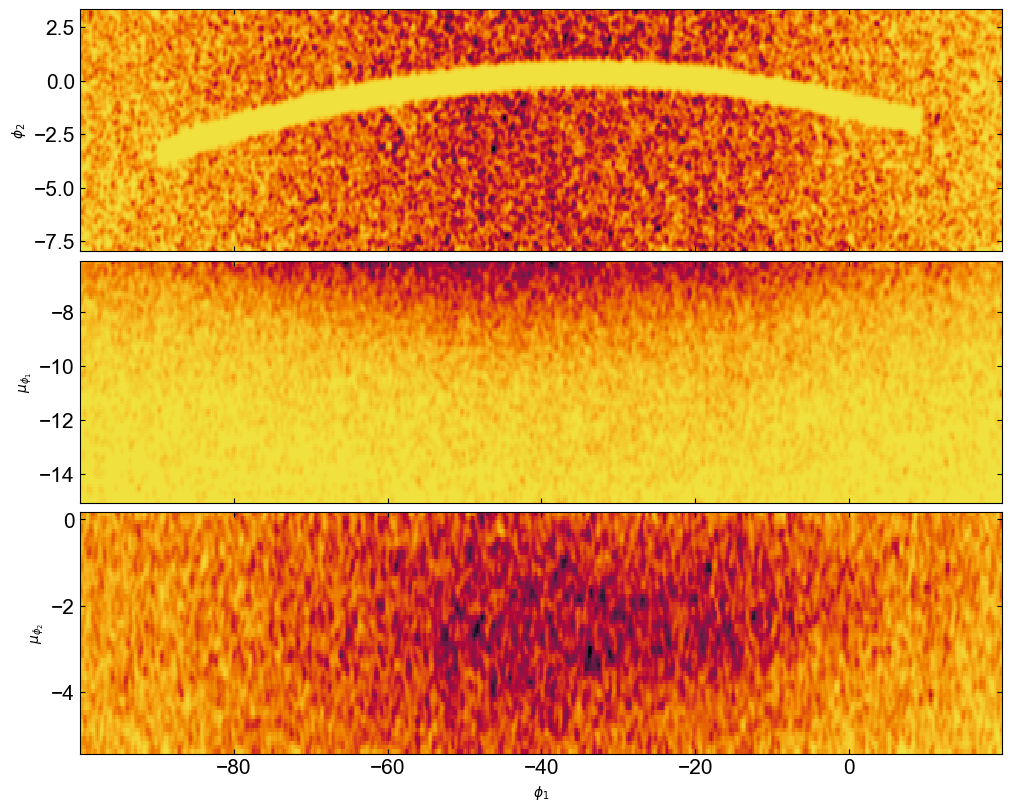

In [12]:
plot_data_projections(data=bkg_data, grids=Base.default_grids,
                      smooth=1);

# Background

In [13]:
BackgroundModel.bkg_update(p, cat)

In [14]:
bkg_init_p = {
    "ln_N": np.log(len(bkg_data['phi1'])),
    #"phi1": {'zs': np.array([-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5])+1},
    "phi1": {'zs': np.zeros(BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(BackgroundModel.pm1_knots, 0),
        "ln_std1": np.full_like(BackgroundModel.pm1_knots, 1),
        "mean2": np.full_like(BackgroundModel.pm1_knots, 5),
        "ln_std2": np.full_like(BackgroundModel.pm1_knots, 2)
    },
    "pm2": {
        "w": np.full_like(BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(BackgroundModel.pm2_knots, -2.),
        "ln_std1": np.full_like(BackgroundModel.pm2_knots, 1),
        "mean2": np.full_like(BackgroundModel.pm2_knots, -3),
        "ln_std2": np.full_like(BackgroundModel.pm2_knots, 2)
    },
}

background_init = BackgroundModel(bkg_init_p)

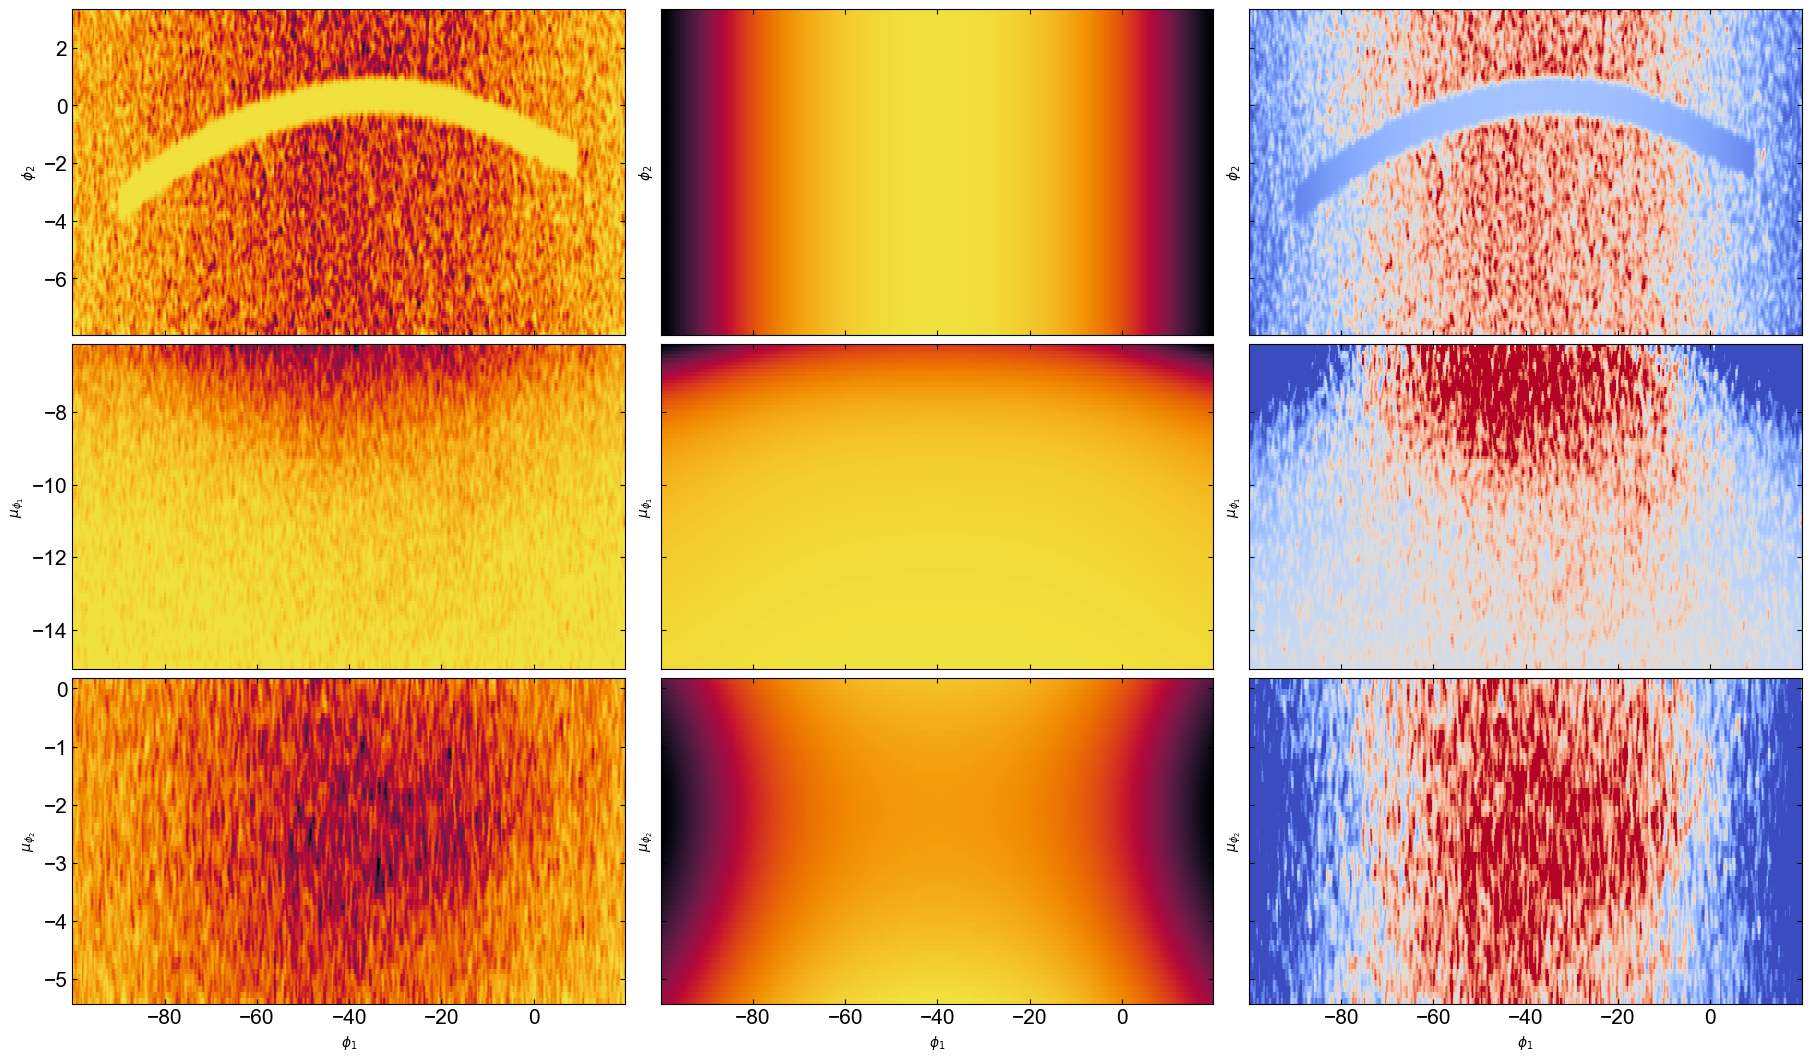

In [15]:
fig, axes = plt.subplots(
    len(background_init.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_init.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=background_init.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_init.plot_model_projections(axes=axes[:, 1])
background_init.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

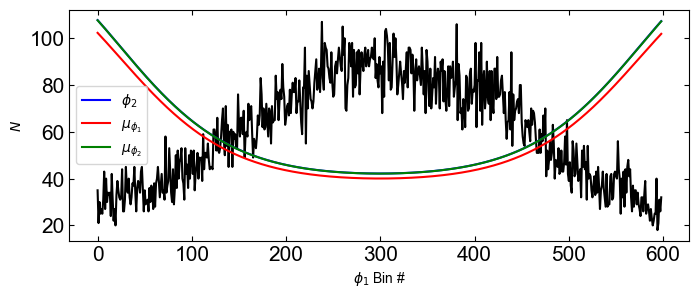

In [16]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_init.default_grids["phi1"], background_init.default_grids['phi2'])
)

grids, ln_ns = background_init.evaluate_on_2d_grids()

fig, ax1 = plt.subplots(1,1,figsize=(8, 3))
ax1.plot(H_data1.sum(axis=1), c='k')
ax1.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b', label=r'$\phi_2$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='r', label=r'$\mu_{\phi_1}$')
ax1.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='g', label=r'$\mu_{\phi_2}$')
ax1.set_xlabel(r'$\phi_1$ Bin #')
ax1.set_ylabel(r'$N$')
ax1.legend()
plt.show()

In [17]:
# def optimize(cls, data, init_params, jaxopt_kwargs=None, use_bounds=True, **kwargs):
#     """
#     A wrapper around numpyro_ext.optim utilities, which enable jaxopt optimization
#     for numpyro models.
#     """
#     import jaxopt

#     if jaxopt_kwargs is None:
#         jaxopt_kwargs = {}
#     jaxopt_kwargs.setdefault("maxiter", 1024)  # TODO: TOTALLY ARBITRARY

#     optimize_kwargs = kwargs
#     #jaxopt_kwargs.setdefault("method", "L-BFGS-B")
#     optimize_kwargs["bounds"] = cls._get_jaxopt_bounds()
#     optimize_kwargs["bounds"] = (
#         cls._normalize_variable_keys(optimize_kwargs["bounds"][0]),
#         cls._normalize_variable_keys(optimize_kwargs["bounds"][1]),
#     )
#     Optimizer = jaxopt.LBFGSB

#     optimizer = Optimizer(**jaxopt_kwargs, fun=cls._objective)
#     opt_res = optimizer.run(
#         init_params=cls._normalize_variable_keys(init_params),
#         data=cls._normalize_variable_keys(data),
#         **optimize_kwargs,
#     )
#     return cls._expand_variable_keys(opt_res.params), opt_res.state

In [18]:
bkg_opt_pars, bkg_info = BackgroundModel.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = BackgroundModel(bkg_opt_pars)
bkg_info

ScipyMinimizeInfo(fun_val=Array(1.09501956, dtype=float64, weak_type=True), success=True, status=0, iter_num=1569, hess_inv=LbfgsInvHessProduct(sk=[[-1.11375453e-05 -6.83056394e-05  2.00713872e-05 ... -5.77772661e-05
   8.06513047e-05 -1.13912681e-05]
 [ 7.16481482e-06 -2.24071383e-04  1.30132855e-05 ...  4.01019225e-06
   1.84450845e-04 -1.37519900e-04]
 [-1.51457287e-05 -2.16492587e-04 -5.56441436e-05 ... -1.81048819e-04
   6.54499551e-05 -2.57495511e-04]
 ...
 [ 9.15530140e-05  4.49524631e-05  2.45231128e-05 ... -1.17888883e-05
  -4.14592398e-05  1.45581971e-04]
 [-6.03349210e-05 -5.44666822e-05  5.54344913e-05 ... -1.62753328e-04
   7.93225494e-05  7.31997758e-05]
 [-6.86704969e-05 -1.07603750e-04  7.11064273e-05 ... -2.00988647e-04
   1.38008186e-04  1.03080844e-04]], yk=[[-1.11371612e-05 -2.61284317e-08 -4.91506435e-08 ... -1.03668443e-06
   5.64346737e-08  8.61302130e-07]
 [ 7.16455349e-06 -2.56046949e-07 -5.83725500e-07 ...  6.61874705e-06
  -8.57902064e-07 -1.79429828e-06]
 [-

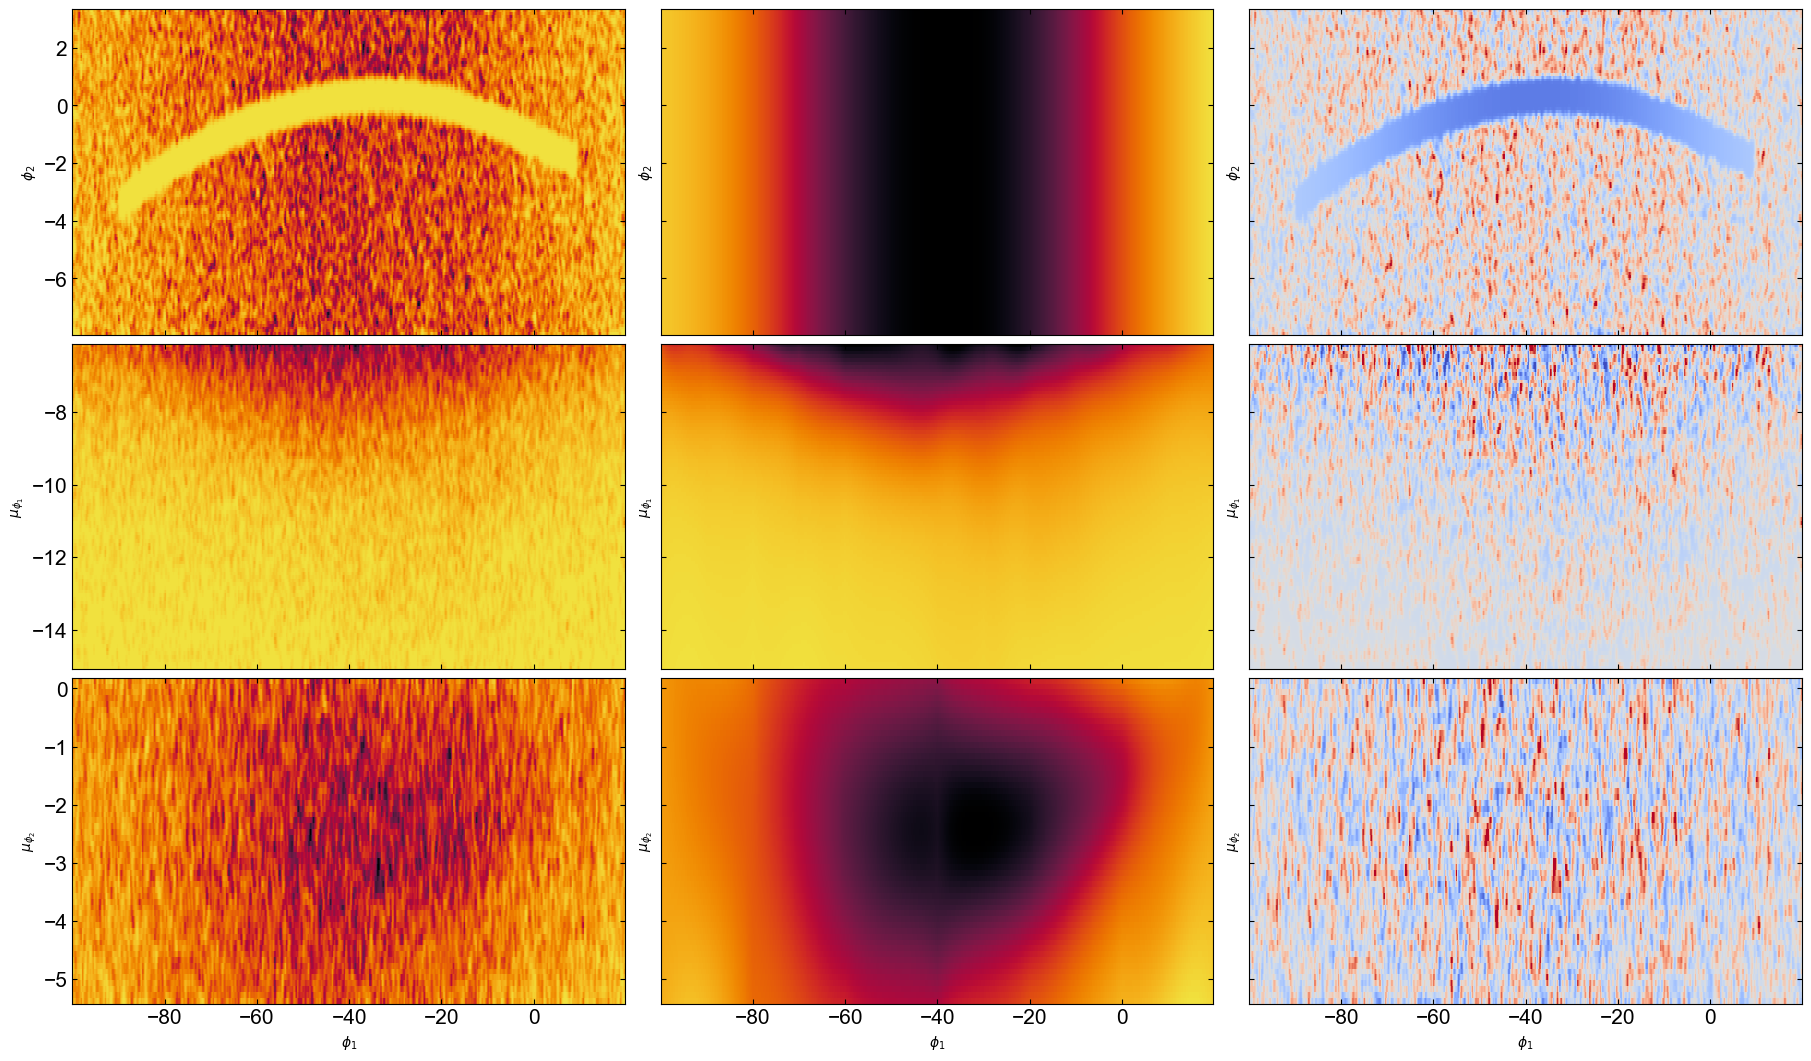

In [19]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")
fig.savefig('test_residual.png')

# Stream

In [20]:
StreamDensModel.stream_dens_update(p, cat)

In [21]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-90, 10, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-80, 0, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-80, 0, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [22]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

        Use @ instead. [gala.coordinates.greatcircle]


In [23]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(StreamDensModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(StreamDensModel.phi2_knots),
        "ln_std": np.full_like(StreamDensModel.phi2_knots, -0.5)
    },
    "pm1": {
        "mean": _pm1_interp(StreamDensModel.pm1_knots),
        "ln_std": np.full_like(StreamDensModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(StreamDensModel.pm2_knots),
        "ln_std": np.full_like(StreamDensModel.pm2_knots, -1)
    }
}

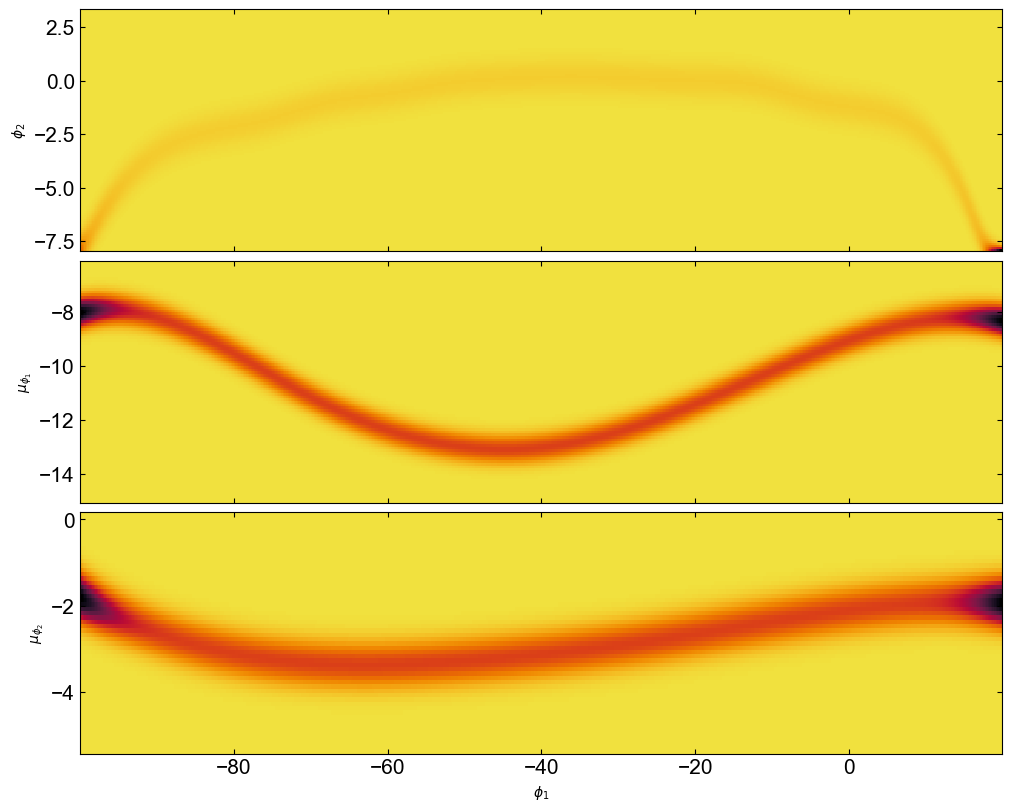

In [24]:
stream_init = StreamDensModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [25]:
stream_init_p

{'ln_N': 7.213768308118642,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-8.24173464e+00, -3.94275792e+00, -2.45380428e+00, -1.86048381e+00,
         -1.03345995e+00, -6.09293270e-01, -1.24647260e-01,  1.07382560e-01,
          1.90458005e-01,  1.01875714e-01, -1.09002246e-02, -2.10482943e-01,
         -9.78888123e-01, -1.46285210e+00, -3.47866945e+00, -1.11767565e+01]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
         -0.5, -0.5, -0.5, -0.5, -0.5])},
 'pm1': {'mean': array([ -8.01001683,  -8.77103687, -11.15172538, -12.76884808,
         -13.02597313, -11.97714145, -10.18789344,  -8.59629562,
          -8.319378  ]),
  'ln_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([-1.80139711, -3.24562548, -3.27612745, -2.78970842, -2.09902308,
         -1.99723637]),
  'ln_

In [26]:
stream_opt_pars, info = StreamDensModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True
)
stream_opt = StreamDensModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.99552821, dtype=float64, weak_type=True), success=False, status=1, iter_num=1024, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  4.17134362e-05 -9.54982707e-06
  -6.80750577e-05  3.14436906e-05 -2.89398246e-05 -4.90445923e-05
  -4.29069446e-06 -2.02214533e-05  4.25009353e-06  9.57963740e-06
  -5.71744650e-05  5.08785248e-06 -9.75488033e-06 -3.84940278e-05
  -2.41551518e-06 -9.39035625e-05  0.00000000e+00 -2.90496229e-06
   5.24123007e-05 -1.04340250e-04 -1.03957497e-04  0.00000000e+00
   6.62566243e-05  1.88001860e-05  5.10617401e-06  1.04802163e-06
   1.22893558e-07 -1.97976523e-05 -1.14893313e-05 -1.86894514e-06
  -1.02070910e-05  1.24044782e-06  1.85029119e-05  1.13393678e-06
  -2.93991262e-06  1.55795292e-05 -1.06096243e-05  1.59379176e-05
  -1.06871607e-05 -1.34152978e-06  1.09186229e-05 -1.19775222e-05
   1.46869838e-05 -8.64699770e-06  5.46531717e-06 -6.739214

Text(0, 0.5, '$\\phi_2$')

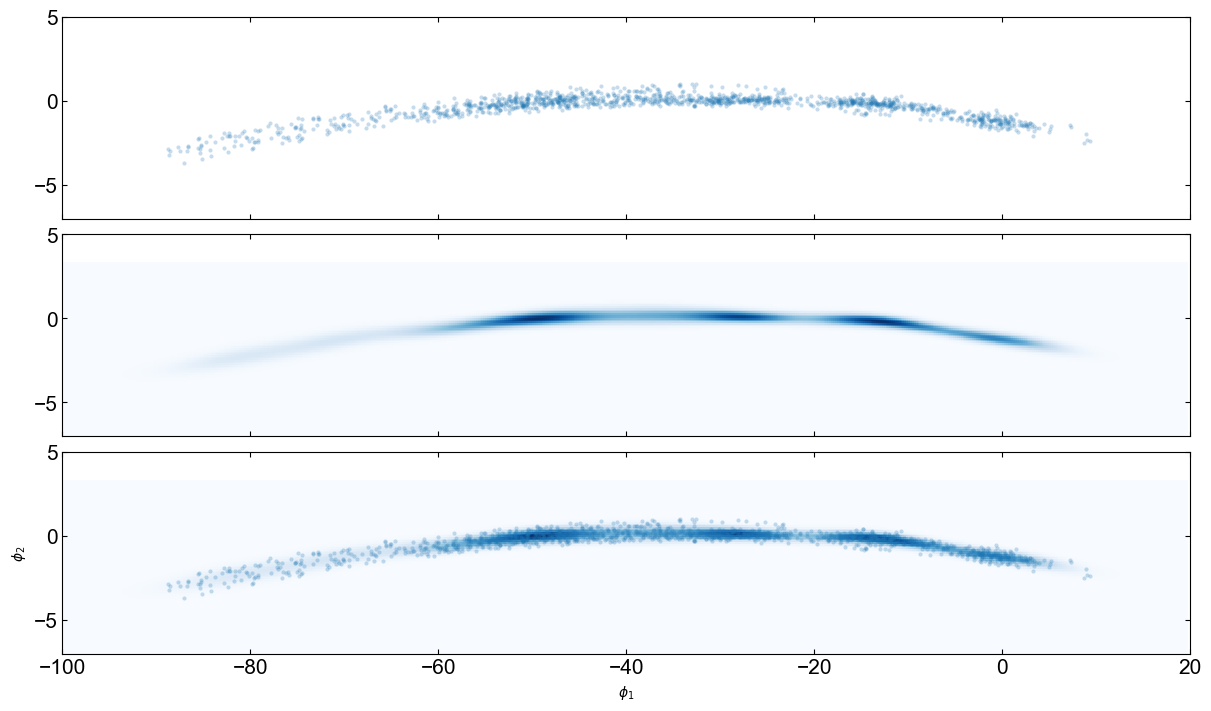

In [27]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

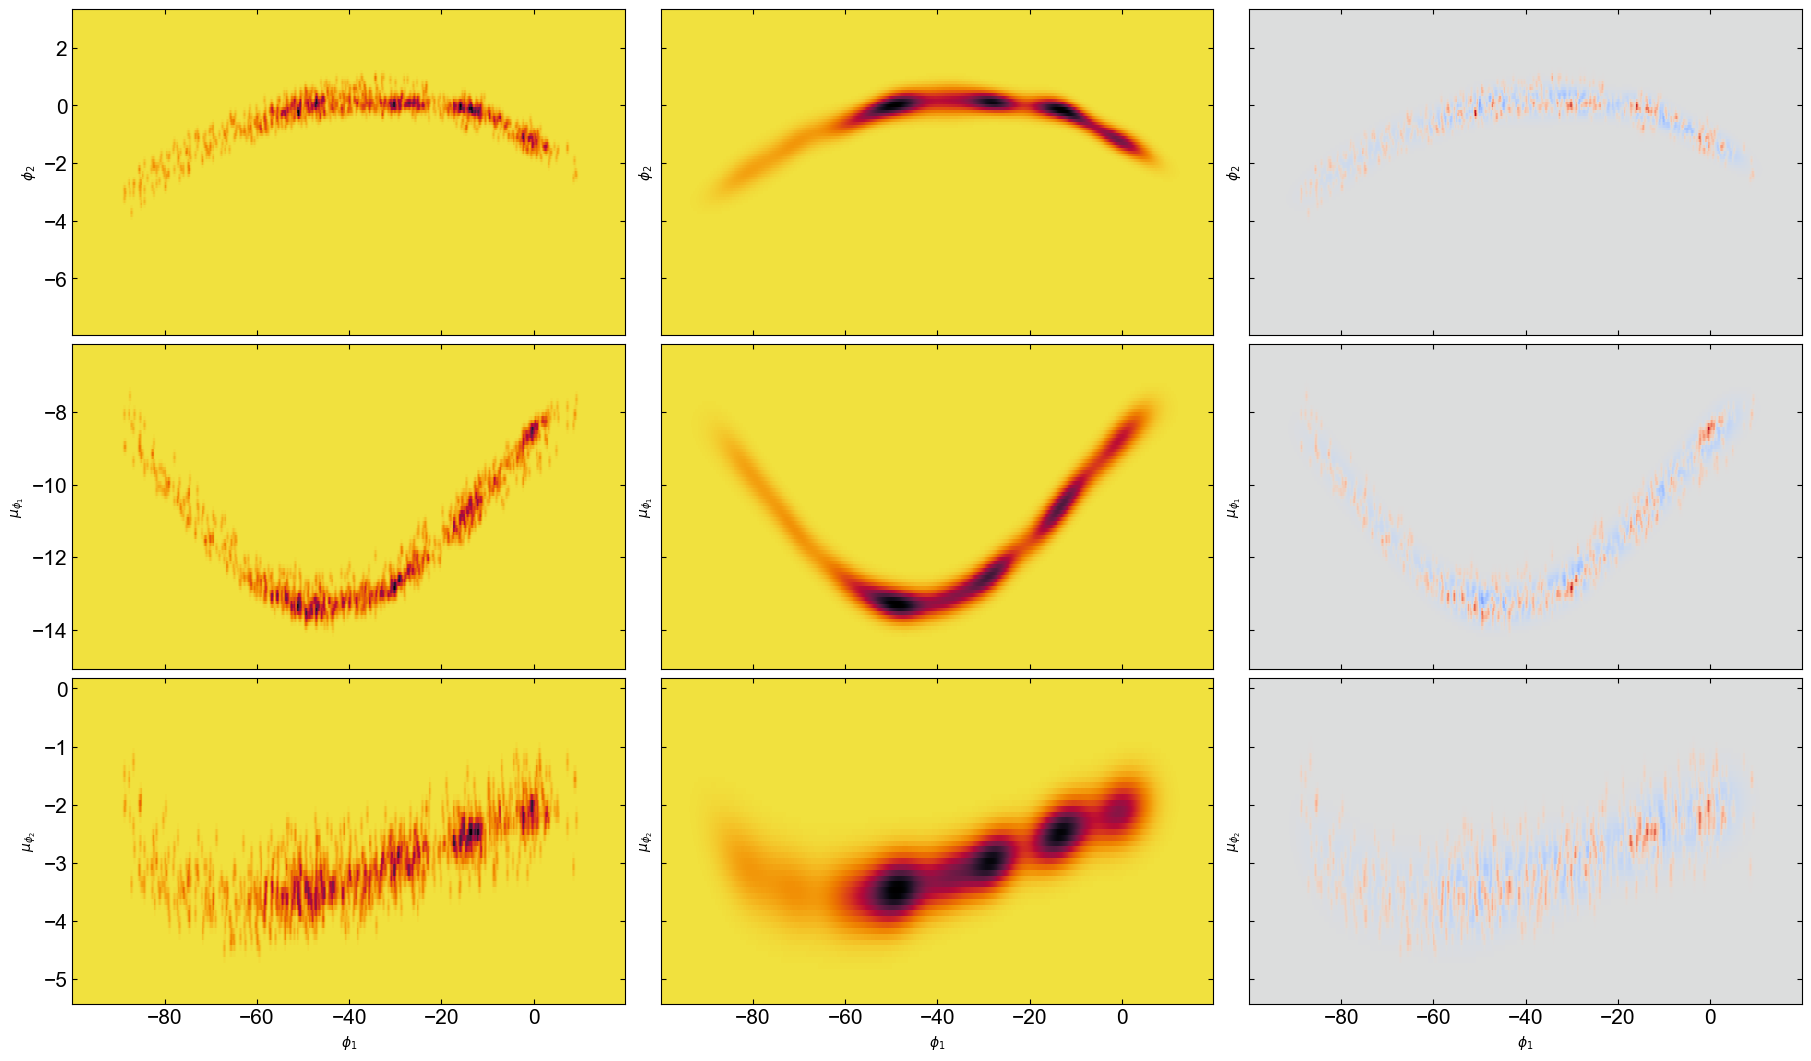

In [28]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [29]:
Components = [StreamDensModel, BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [30]:
mix_init = StreamMixtureModel(mix_params0, Components)

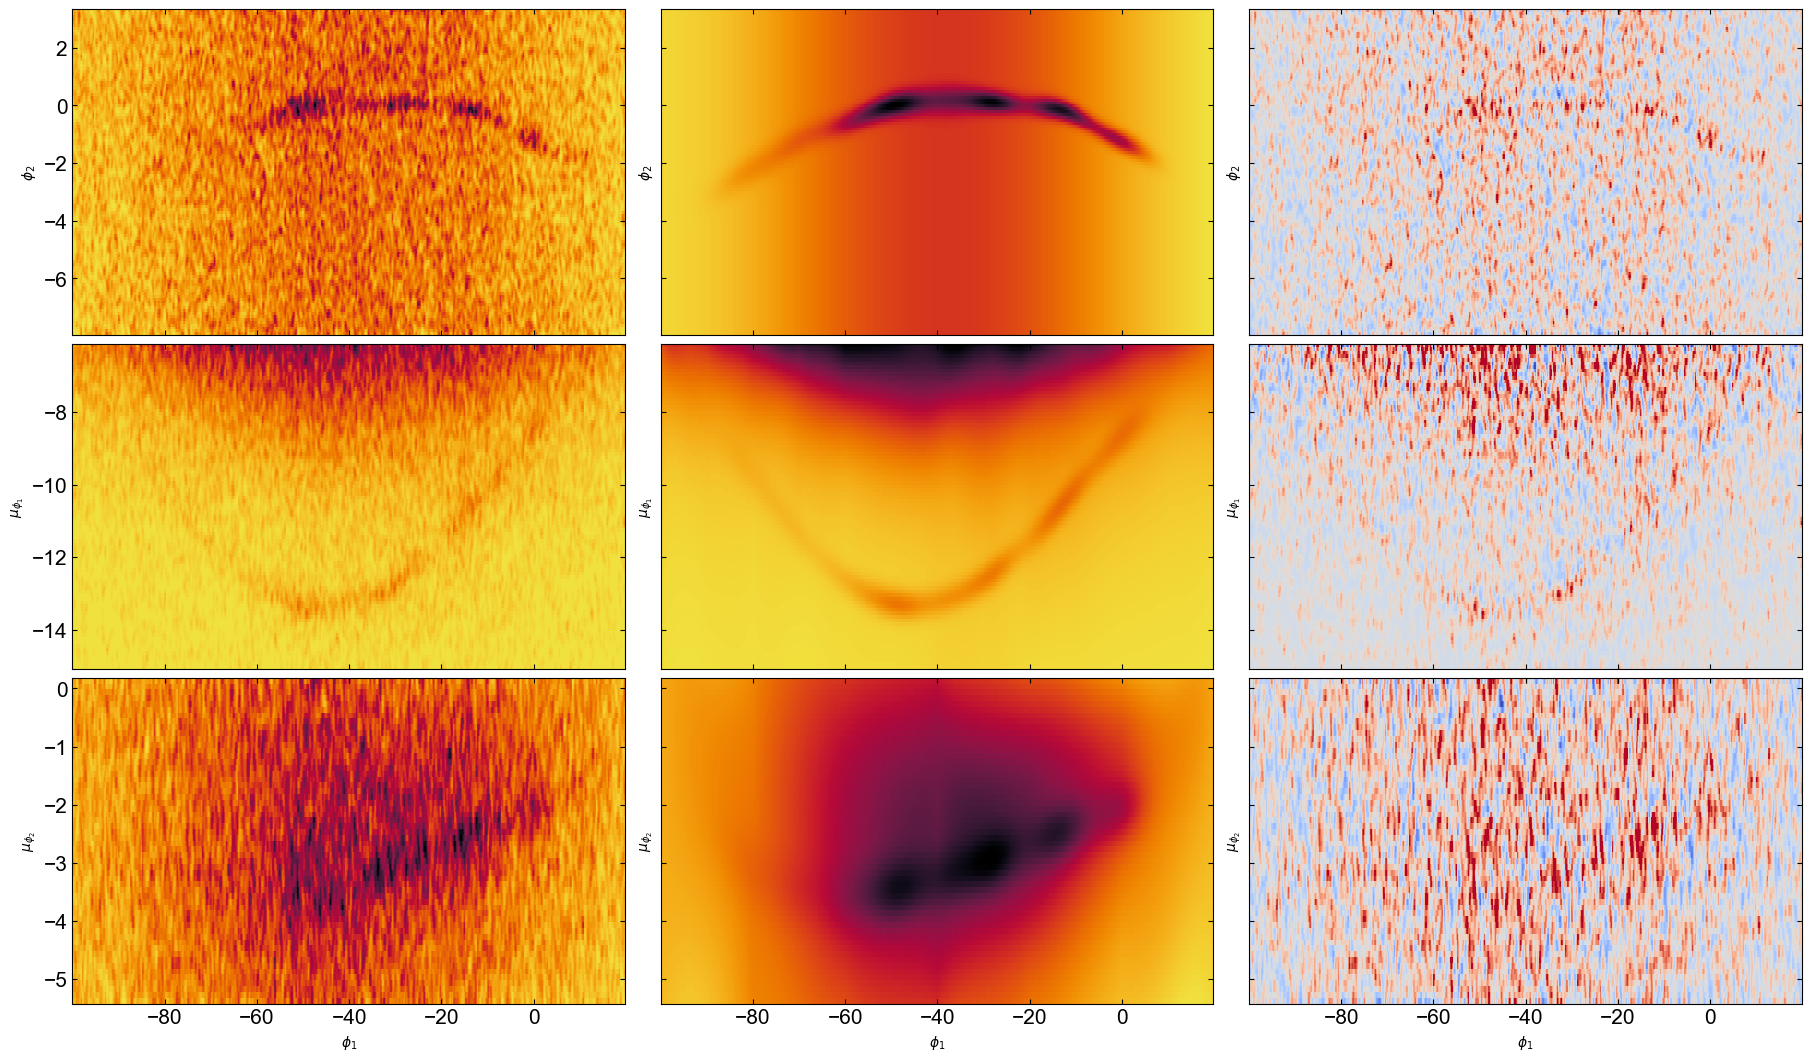

In [31]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [32]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(0.89157842, dtype=float64, weak_type=True), success=True, status=0, iter_num=1333, hess_inv=LbfgsInvHessProduct(sk=[[ 1.10998344e-04  4.40199239e-04  2.40871223e-04 ... -6.36641520e-05
   1.02940310e-04 -4.65128033e-04]
 [-1.47637387e-05 -1.33302192e-04  3.67159330e-05 ... -3.22933109e-05
   4.08765209e-05  2.31544276e-04]
 [-4.50227969e-05  2.32672875e-05  2.21381292e-05 ... -9.22136102e-07
  -1.79545281e-06  6.92137479e-05]
 ...
 [-2.32967824e-05  1.77019211e-04 -1.74083400e-05 ...  4.18688937e-05
  -5.67548653e-05 -2.71517324e-04]
 [-1.44825209e-05  3.66845020e-04  9.39623380e-05 ...  8.11501378e-06
  -9.85099626e-06 -5.11149183e-04]
 [-9.28311516e-05  6.52980073e-04  2.90238178e-04 ... -1.32549570e-04
   1.65774053e-04 -7.72226126e-04]], yk=[[ 1.09894538e-04  1.36716959e-08  3.91492470e-06 ... -2.18661260e-06
   3.88756800e-06  1.69151275e-07]
 [-1.51561789e-05  1.85963101e-09  4.50470428e-07 ... -1.63018480e-06
   2.10284719e-06  2.22661578e-07]
 [-

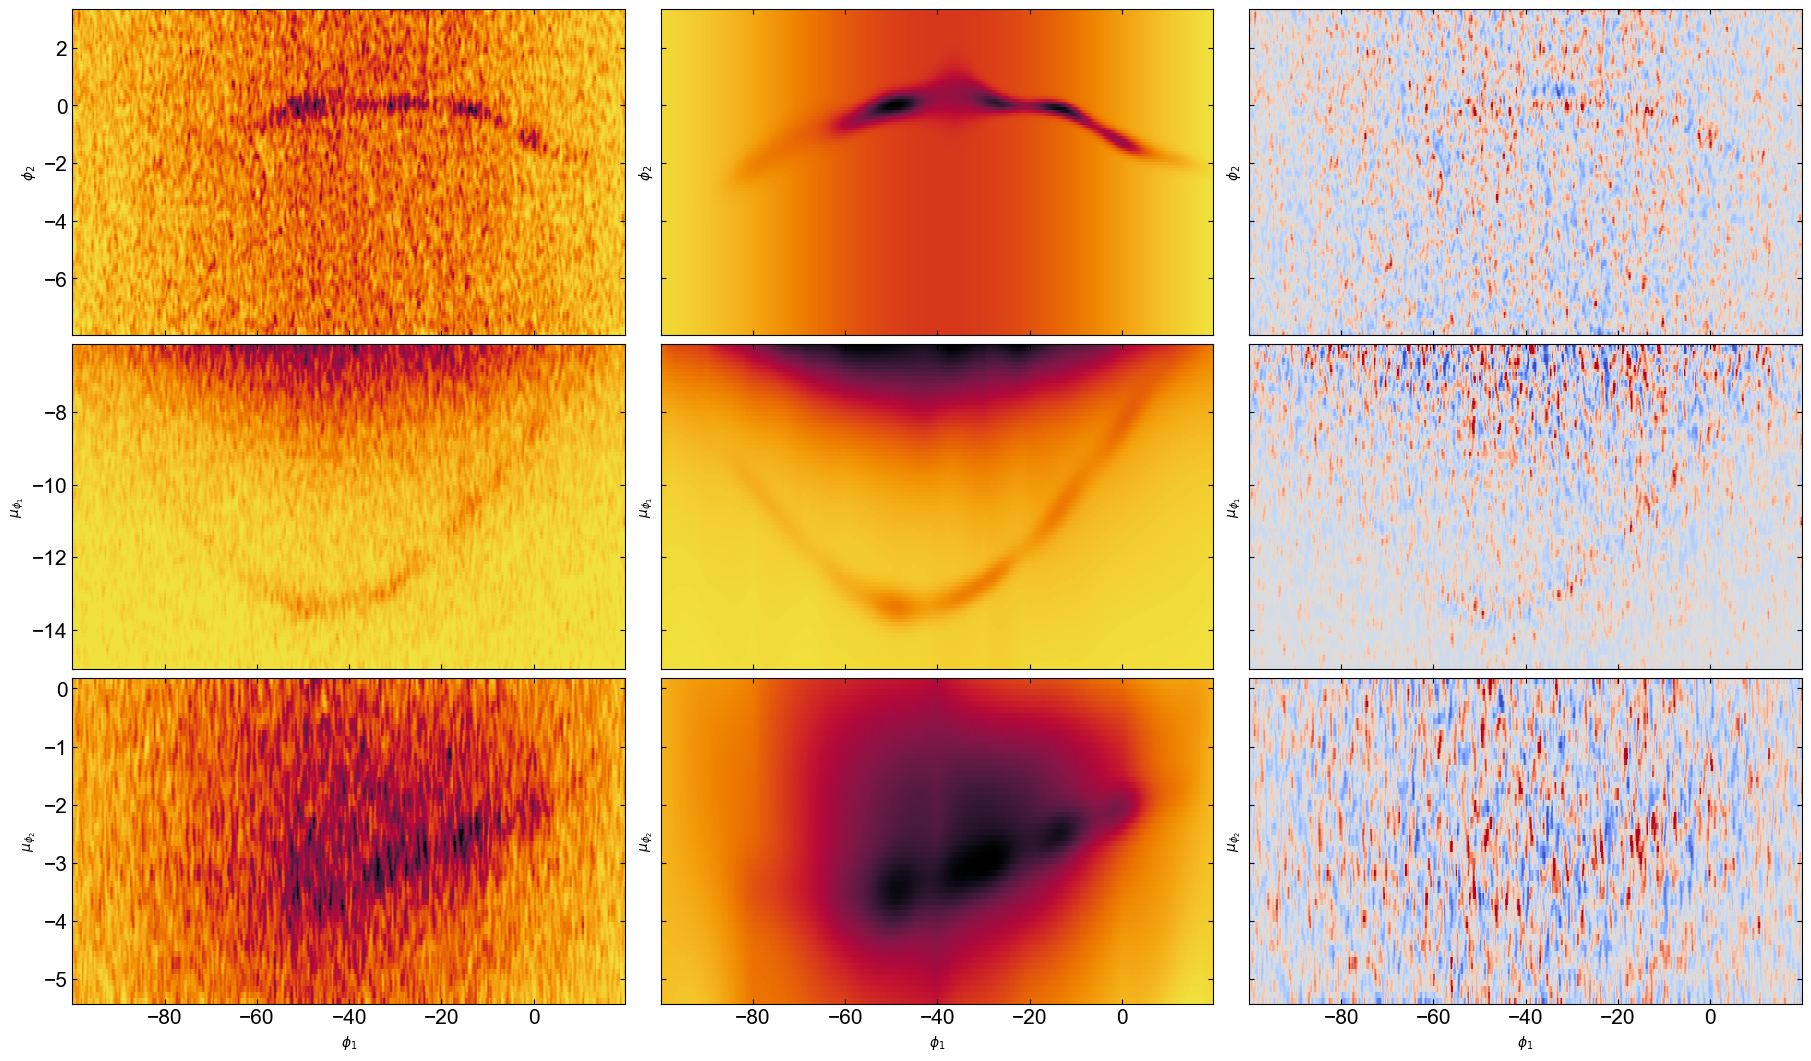

In [33]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [34]:
OffTrackModel.offtrack_update(p, cat)

In [35]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

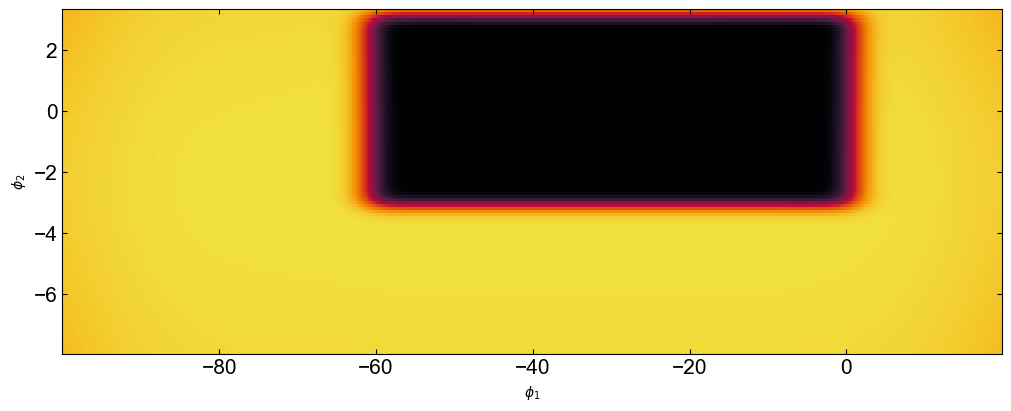

In [36]:
offtrack_model0 = OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [37]:
full_Components = [StreamDensModel, BackgroundModel, OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [38]:
tied_params = [
    (("offtrack", "pm1"), ("stream", "pm1")),
    (("offtrack", "pm2"), ("stream", "pm2")),
]
full_mix_init = StreamMixtureModel(
    full_mix_params0, full_Components, tied_params=tied_params
)

In [39]:
full_mix_params0['offtrack'][('phi1', 'phi2')]['zs'].shape

(874,)

In [40]:
tied_params

[(('offtrack', 'pm1'), ('stream', 'pm1')),
 (('offtrack', 'pm2'), ('stream', 'pm2'))]

In [ ]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    #tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

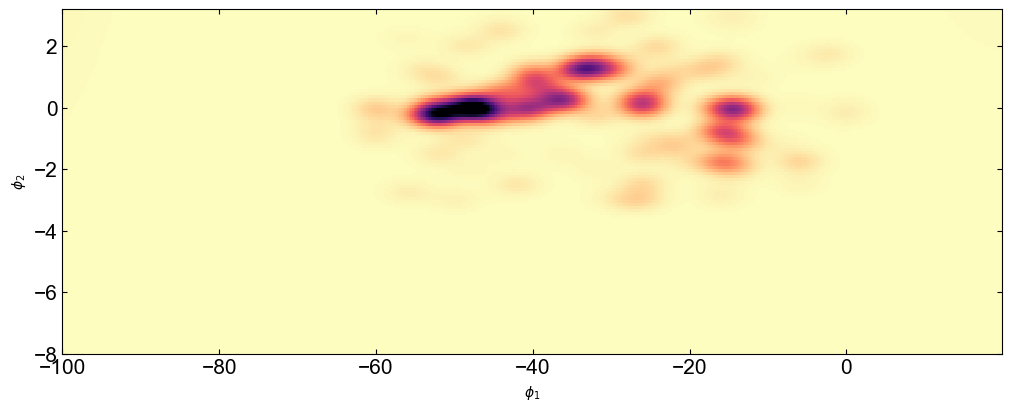

In [75]:
import copy
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = GD1OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

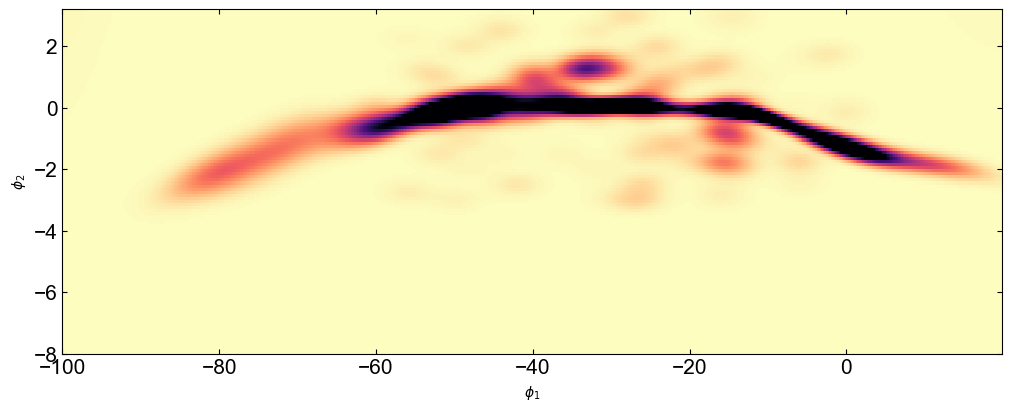

In [76]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

(<Figure size 1000x400 with 1 Axes>,
 array([<Axes: xlabel='$\\phi_1$', ylabel='$\\phi_2$'>], dtype=object))

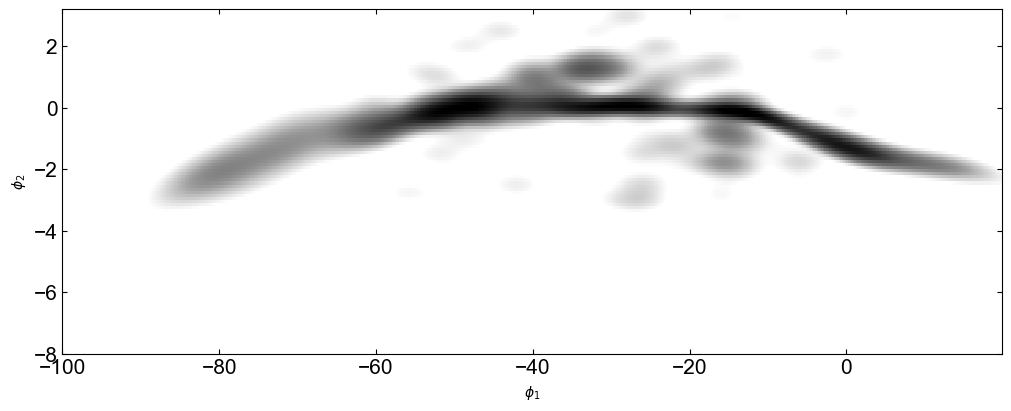

In [77]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

(<Figure size 800x800 with 3 Axes>,
 array([<Axes: ylabel='$\\phi_2$'>, <Axes: ylabel='$\\mu_{\\phi_1}$'>,
        <Axes: xlabel='$\\phi_1$', ylabel='$\\mu_{\\phi_2}$'>],
       dtype=object))

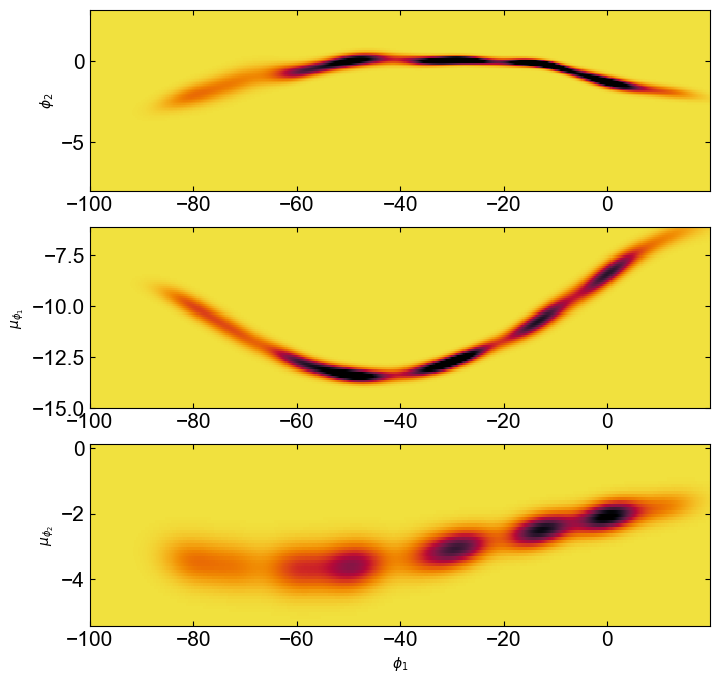

In [82]:
fig, axs = plt.subplots(3,1,figsize=(8,10))
full_stream_opt = GD1StreamModel(full_mix_opt_pars['stream'])
full_stream_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5), axes=axs)

In [81]:
full_mix_opt_pars['stream']

{'ln_N': Array(7.03706969, dtype=float64),
 'phi1': {'zs': Array([-7.37626437, -7.6583479 , -8.        , -8.        , -8.        ,
         -5.02425777,  0.5406238 , -4.54503195,  0.32904079, -1.54314444,
         -3.79818606,  0.96765485, -1.88551909,  0.58504156,  1.19630787,
         -4.4654777 , -2.38322058,  0.14321783,  0.38679703,  1.396316  ,
         -7.07405701, -7.40611595,  0.31449392,  1.71531717, -6.42651825,
         -5.18321947,  3.16739992, -8.        ,  1.00957904,  8.        ,
          3.20953424,  0.85423195], dtype=float64)},
 'phi2': {'ln_std': Array([-0.87416611, -0.88409819, -0.87034153, -0.71859818, -0.77287848,
         -1.21673017, -1.39970243, -1.48266333, -1.74829516, -1.93707973,
         -1.93313831, -1.97178721, -1.63594016, -1.55971143, -1.52073622,
         -1.49376808], dtype=float64),
  'mean': Array([-3.08506317, -3.16330564, -2.46418878, -1.72245427, -0.94234142,
         -0.64553855, -0.10985543,  0.14784986,  0.0275281 ,  0.06451962,
         -0

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

KeyError: 'phi1'

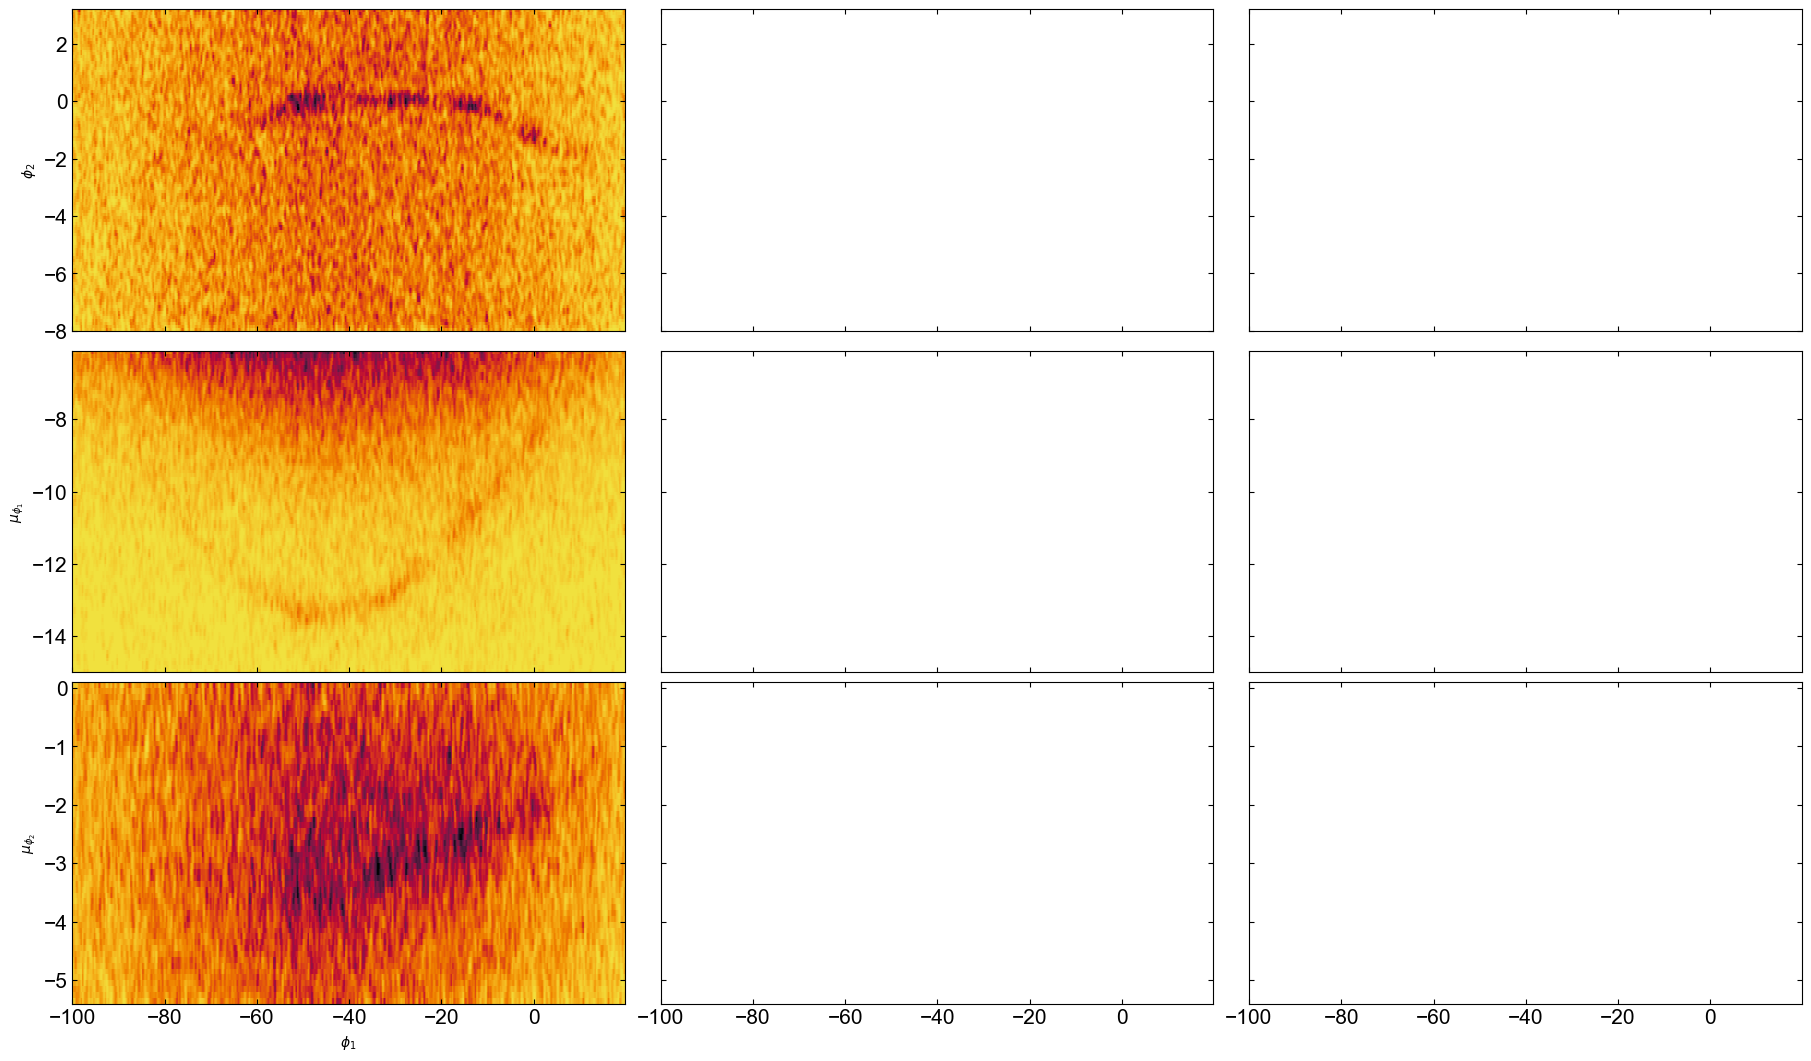

In [80]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt.plot_model_projections(axes=axes[:, 1])
full_mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")